# Meta-analysis

Meta-analysis is used to combine evidence from multiple studies, usually clinical trials testing the effectiveness of therapies or tests. The pooled evidence from multiple studies can give much more precise and reliable answers than any single study can. Although many researchers are convinced that meta-analyses are hugely important and helpful, others doubt that meta-analysis can consistently overcome the huge challenges and produce consistently useful results:

- inconsistent criteria to define a disease => define which patients are included
- different outcome variables => define which outcomes are included
- unpublished studies/publication bias => seek unpublished data, review registries of study protocols
- some studies are of higher quality than others => define what makes a study of high enough quality to be included
- different languages => arrange for translation
- not enough information to perform a proper analysis => estimate data from figures, obtain unpublished details from investigators
- published data may be internally inconsistent => resolve inconsistencies without bias, request details from investigators
- data from some patients may be included in multiple publications, redundant analyses => ask investigators to clarify which patients were included in more than one publication

A meta-analysis pools weighted effect sizes, it calculates a pooled P value from the pooled effect size.

Meta-analyses don't have to be huge, it can be helpful to combine the results from as few as two studies.

## Assumptions of meta-analysis

There are two general methods that are used, each of which is based on different assumptions:

- _fixed effects_: this model assumes that all the subjects in all the studies were really sampled from one large population. Thus, all teh studies are estimating the same effect, and the only difference between studies is due to random selection of subjects.
- _random effects_: this model assumes that each study population is unique. The difference among study results is due both to differences between the populations and to random selection of subjects. This model is more realistic and is used more frequently.

In [174]:
# We use the data extracted from Figure 43.1 on page 455
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [175]:
mean = np.array([2.5, 1.4, 1.1, 1.2,  .8,  .8, 1.1, np.NaN, 1.2])
lower= np.array([1.8,  .8,  .8,  .8,  .5,  .4,  .6, np.NaN,  .9])
upper= np.array([4.4, 2.2, 1.8, 1.9, 1.4, 1.6, 2,   np.NaN, 1.4])
W = (upper-lower)/2

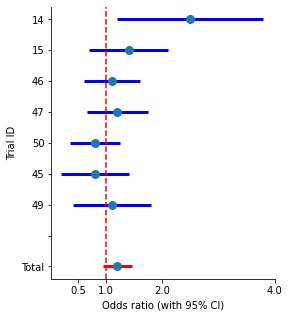

In [176]:
plt.figure(figsize=(4,5))
plt.errorbar(
    x=np.flip(mean),
    y=np.arange(len(mean)),
    xerr=np.flip(W),
    fmt='o',
    ms=8,
    ecolor=['red']+['blue']*8,
    elinewidth=3,
)

plt.xlabel("Odds ratio (with 95% CI)")
plt.xticks([0.5, 1, 2, 4.0])
plt.ylabel("Trial ID")
plt.yticks(
    list(range(0,9)),
    ['Total', '', '49', '45', '50', '47', '46', '15', '14'])
plt.axvline(x=1, color='red', linestyle='--')
sns.despine();

## Results from a meta-analysis

Part of a meta-analysis is a narrative report that summarizes the studies that have been done and evaluates their strengths and weaknesses. The rest of a meta-analysis is quantitative. The results of each study are summarized by one value, called the **effect size**, along with its CI. The effect size is usually a relative risk or odds ratio, but it could also be some other measure of treatment effect. Combining all the studies, the meta-analysis computes the pooled treatment effect, its CI and a pooled P value.

The results for the individual studies and the pooled results are plotted on a **forest plot** or **blobbogram**.

In the example above, the forest plot shows the results from 7 studies of the effectiveness of a drug, the horizontal axis is the odds ratio, a value of 1.0 means no effect; a value greater than 1.0 means the drug works better than placebo. The top 7 lines are results of individual studies. For each study, the plot shows the odds ratio and 95% confidence interval. At the very bottom, the graph shows the total (pooled) effect computed from all studies, also shown as an odds ratio with its 95% CI.

In 6 of the 7 studies, the 95% CI includes 1.0. With 95% confidence, you cannot conclude from these six studies that the treatment works better than placebo. In only 1 of the studies, does the 95% CI not include 1.0. The data from this study, but not the others, would lead you to conclude with 95% confidence that the treatment worked better than placebo. The bottom part of the graph shows the total (pooled) effect as computed by the meta-analysis. The 95% CI ranges from 0.98 to 1.56, so the P value must be greater than 0.05. The overall odds ratio is 1.24. That is a small effect, but not a tiny one. The 95% CI includes 1.0 (no effect), but just barely.

### Meta-analysis of individual participant data (IPD meta-analysis)

A newer approach is for the meta-analysts to obtain the original data for each participant of each study, and reanalyze all the data together. This approach is considered the gold standard of meta-analysis and has determined definitive answers to clinical questions, which might not have been obtained from meta-analysis of summay data. This type of analysis ensures that the outcomes are defined in a consistent way, and that the data are analyzed using the same methods. Moreover, it can include more data than did the original paper because one get data at the root from the investigators, it can answer questions not posed by the original investigators, run subgroup analyses and account for confounding variables not considered by the original investigators.

## Meta-analysis of continuous data (standardized mean difference or SMD)

### Implementation with statsmodels.stats.meta_analysis

Statsmodels include basic methods for [meta-analysis](https://www.statsmodels.org/stable/examples/notebooks/generated/metaanalysis1.html). The support for meta-analysis has 3 parts:

- effect size functions: this currently includes `effectsize_smd` computes effect size and their standard errors for standardized mean difference, `effectsize_2proportions` computes effect sizes for comparing two independent proportions using risk difference, (log) risk ratio, (log) odds-ratio or arcsine square root transformation
- The `combine_effects` computes **fixed and random effects estimate** for the overall mean or effect. The returned results instance includes a forest plot function.
- helper functions to estimate the random effect variance, tau-squared

In [177]:
from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
)

In [178]:
data = [
    ["Carroll", 94, 22, 60, 92, 20, 60],
    ["Grant", 98, 21, 65, 92, 22, 65],
    ["Peck", 98, 28, 40, 88, 26, 40],
    ["Donat", 94, 19, 200, 82, 17, 200],
    ["Stewart", 98, 21, 50, 88, 22, 45],
    ["Young", 96, 21, 85, 92, 22, 85],
]
colnames = ["study", "mean_t", "sd_t", "n_t", "mean_c", "sd_c", "n_c"]
dframe1 = pd.DataFrame(data, columns=colnames).set_index('study')

mean2, sd2, nobs2, mean1, sd1, nobs1 = np.asarray(
    dframe1
).T

In [179]:
dframe1

,mean_t,sd_t,n_t,mean_c,sd_c,n_c
study,,,,,,
Carroll,94,22,60,92,20,60
Grant,98,21,65,92,22,65
Peck,98,28,40,88,26,40
Donat,94,19,200,82,17,200
Stewart,98,21,50,88,22,45
Young,96,21,85,92,22,85


In [180]:
# one-step chi2, DerSimonian-Laird estimate for random effects variance tau
eff1, var_eff1 = effectsize_smd(mean2, sd2, nobs2, mean1, sd1, nobs1)

In [181]:
eff1

array([0.09452437, 0.2773564 , 0.36654635, 0.6643851 , 0.46180798,
       0.18516464])

In [182]:
#Uone-step chi2, DerSimonian-Laird estimate for random effects variance tau
res1 = combine_effects(eff1, var_eff1, method_re="chi2", use_t=False, row_names=dframe1.index)

In [183]:
print("method RE:", res1.method_re)
print("tau2=", res1.tau2)

method RE: chi2
tau2= 0.03723180584080541


In [184]:
nobs=np.array(nobs1 + nobs2)
print(res1.summary_frame())

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Carroll            0.094524  0.182680 -0.263521  0.452570  0.123885  0.157529
Grant              0.277356  0.176279 -0.068144  0.622857  0.133045  0.162828
Peck               0.366546  0.225573 -0.075569  0.808662  0.081250  0.126223
Donat              0.664385  0.102748  0.463002  0.865768  0.391606  0.232734
Stewart            0.461808  0.208310  0.053527  0.870089  0.095275  0.137949
Young              0.185165  0.153729 -0.116139  0.486468  0.174939  0.182736
fixed effect       0.414961  0.064298  0.288939  0.540984  1.000000       NaN
random effect      0.358486  0.105462  0.151785  0.565187       NaN  1.000000
fixed effect wls   0.414961  0.099237  0.220460  0.609462  1.000000       NaN
random effect wls  0.358486  0.090328  0.181446  0.535526       NaN  1.000000


In [185]:
res1.conf_int_samples(use_t=True, nobs=np.array(nobs1 + nobs2))

(array([-0.26719942, -0.07141628, -0.08244568,  0.46238908,  0.04820269,
        -0.1183121 ]),
 array([0.45624817, 0.62612908, 0.81553838, 0.86638112, 0.87541326,
        0.48864139]))

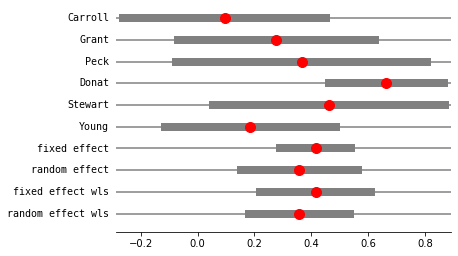

In [186]:
fig = res1.plot_forest()

### Another example with the effect being the mean of measurements (fixed-effect)

In [187]:
eff2 = np.array(
    [61.00,  61.40,  62.21,  62.30,  62.34,  62.60,  62.70,  62.84,  65.90 ]
)
var_eff2 = np.array(
    [0.2025, 1.2100, 0.0900, 0.2025, 0.3844, 0.5625, 0.0676, 0.0225, 1.8225]
)
rownames2 = [
    "PTB",   "NMi",  "NIMC", "KRISS","LGC",  "NRC",  "IRMM", "NIST", "LNE" 
]

method RE: dl
                       eff  sd_eff   ci_low   ci_upp    w_fe    w_re
PTB                61.0000  0.4500  60.1180  61.8820  0.0574  0.1231
NMi                61.4000  1.1000  59.2440  63.5560  0.0096  0.0403
NIMC               62.2100  0.3000  61.6220  62.7980  0.1292  0.1597
KRISS              62.3000  0.4500  61.4180  63.1820  0.0574  0.1231
LGC                62.3400  0.6200  61.1248  63.5552  0.0303  0.0898
NRC                62.6000  0.7500  61.1300  64.0700  0.0207  0.0710
IRMM               62.7000  0.2600  62.1904  63.2096  0.1721  0.1698
NIST               62.8400  0.1500  62.5460  63.1340  0.5169  0.1945
LNE                65.9000  1.3500  63.2540  68.5460  0.0064  0.0286
fixed effect       62.5834  0.1078  62.3347  62.8321  1.0000     NaN
random effect      62.3901  0.2457  61.8234  62.9568     NaN  1.0000
fixed effect wls   62.5834  0.1899  62.1455  63.0213  1.0000     NaN
random effect wls  62.3901  0.2948  61.7104  63.0699     NaN  1.0000


C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:106: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


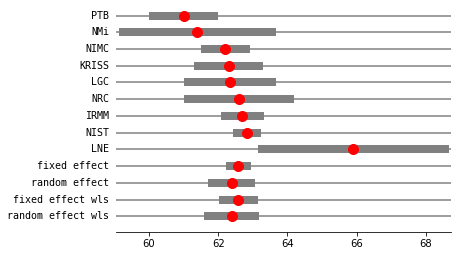

In [188]:
res2_DL = combine_effects(eff2, var_eff2, method_re="dl", use_t=True, row_names=rownames2)
print("method RE:", res2_DL.method_re)
print(round(res2_DL.summary_frame(), 4))
fig = res2_DL.plot_forest()

### Step-by-step Woolf method (fixed-effect)

A very common and simple version of the meta-analysis procedure is commonly referred to as the inverse-variance method. This approach is implemented in its most basic form in RevMan, and is used behind the scenes in many meta-analyses of both dichotomous and continuous data.

The inverse-variance method is so named because the weight given to each study is chosen to be the inverse of the variance of the effect estimate (i.e. 1 over the square of its standard error). Thus, larger studies, which have smaller standard errors, are given more weight than smaller studies, which have larger standard errors. This choice of weights minimizes the imprecision (uncertainty) of the pooled effect estimate.

We assign **weights** based on the inverse of the variance rather than sample size. The inverse variance is roughly proportional to sample size, but is a more nuanced measure, and serves to minimize the variance of the combined effect so that $ w_i = \frac{1}{v_i} $ with $v_i$ the within-study variance for studi $i$.

A fixed-effect meta-analysis using the inverse-variance method calculates a weighted average as, i.e. the weighted mean is then computed as the sum of the products $w_iE_i$, where $E_i$ is the effect size if the individual study, divided by the sum of the weights:

$$ \bar{E} = \frac{\sum_{i=1}^kw_iE_i}{\sum_{i=1}^kw_i} = \frac{\sum E_i(1/\mathrm{SE_i}^2)}{\sum (1/\mathrm{SE_i}^2)} $$

A fixed-effect meta-analysis is valid under an assumption that all effect estimates are estimating the same underlying intervention effect, which is referred to variously as a 'fixed-effect' assumption, a 'common-effect' assumption or an 'equal-effects' assumption.

The variance of the combined effect is $ v = \frac{1}{\sum_{i=1}^kw_i} $, and $ \mathrm{SE}(\bar{E}) = \sqrt{v} $.

The 95% confidence interval for the mean combined effect would then be $ \bar{E} \pm z_{\alpha/2}*\mathrm{SE}(\bar{E}) $ (see the video ["Meta-analysis Prediction Intervals"](https://www.youtube.com/watch?v=DPo88xtPUaA)), it tells nothing about the distribution of the different effect sizes measured but the precision of the mean effect sizes, depending on the number of studies.

Finally, $ Z = \frac{\bar{E}}{\mathrm{SE}(\bar{E})} $, so for a two-tailed test $ p = 2[1-(\phi(|Z|))] $ with $\phi$ the standard normal cumulative function. In the context of Cochrane reviews is either an assumption of 'no effect of the intervention' or 'no differences in the effect of intervention between studies' (_no heterogeneity_). Thus, a P value that is very small indicates that the observed effect is very unlikely to have arisen purely by chance, and therefore provides evidence against the null hypothesis. 

In [189]:
weights2 = 1 / var_eff2
weights2

array([ 4.9382716 ,  0.82644628, 11.11111111,  4.9382716 ,  2.60145682,
        1.77777778, 14.79289941, 44.44444444,  0.54869684])

In [190]:
# getting weights from the combined results
res2_DL.weights_fe

array([ 4.9382716 ,  0.82644628, 11.11111111,  4.9382716 ,  2.60145682,
        1.77777778, 14.79289941, 44.44444444,  0.54869684])

In [191]:
# below corresponds to the `w_fe` column
res2_DL.weights_fe / sum(res2_DL.weights_fe)

array([0.05743554, 0.00961215, 0.12922996, 0.05743554, 0.03025675,
       0.02067679, 0.17205172, 0.51691983, 0.00638173])

In [192]:
E2 = eff2 * weights2
E2

array([ 301.2345679 ,   50.74380165,  691.22222222,  307.65432099,
        162.1748179 ,  111.28888889,  927.5147929 , 2792.88888889,
         36.15912209])

In [193]:
df2 = len(eff2) - 1

E_bar2 = sum(E2) / sum(weights2)
var_bar2 = 1 / sum(weights2)
SE_bar2 = var_bar2**.5
t_crit2 = stats.t(df=df2).ppf((1+.95)/2) # we used t-distribution with combine_effect()

# Z2 = E_bar2/SE_bar2
# pvalue_2 = 2 * (1 - stats.t.cdf(x = abs(Z2), df=df2))

print(f"Combined effect size = {E_bar2:.4f} with SE = {SE_bar2:.4f} and the 95% CI ranging from {E_bar2 - t_crit2*SE_bar2:.4f} to {E_bar2 + t_crit2*SE_bar2:.4f}")
#print(f"Z statistic = {Z2:.2f} with an associated P value = {pvalue_2:.5f}") # not sure that works

Combined effect size = 62.5834 with SE = 0.1078 and the 95% CI ranging from 62.3347 to 62.8321


### Heterogeneity

The classical measure of heterogeneity is **Cochran's $Q$**, which is calculated as the weighted sum of squared differences between individual study effects and the pooled effect across studies, with the weights being those used in the pooling method with $ Q = \sum w_i(E_i-E)^2 $ where $ E = \frac{\sum w_iE_i}{\sum w_i} $.

$Q$ is distributed as a chi-square statistic with k (numer of studies) minus 1 degrees of freedom $Q \sim \chi^2(k-1)$.

$Q$ has low power as a comprehensive test of heterogeneity, especially when the number of studies is small, i.e. most meta-analyses. Conversely, $Q$ has too much power as a test of heterogeneity if the number of studies is large.

The $I^2$ statistic describes the percentage of variation across studies that is due to heterogeneity rather than chance

$$ I^2 = 100\%  \frac{Q - \mathrm{Df}}{Q} $$

$I^2$ is an intuitive and simple expression of the inconsistency of studies' results. Unlike $Q$ it does not inherently depend upon the number of studies considered.

A confidence interval for $I^2$ is constructed using either i) the iterative non-central chi-squared distribution method of Hedges and Piggott; or ii) the test-based method of Higgins and Thompson. The non-central chi-square method is currently the method of choice.

In [194]:
res2_DL.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 24.80189774185419
pvalue = 0.001679351463714887
df = 8
distr = 'chi2'
tuple = (24.80189774185419, 0.001679351463714887)

In [195]:
Q2 = sum(res2_DL.weights_fe * (res2_DL.effect - res2_DL.mean_effect_fe)**2)
I2 = (Q2 - df2)/Q2
pvalue_homogen = 1 - stats.chi2.cdf(x = Q2, df=df2)

print(f"Cochrane Q = {Q2:.3f} and I² = {100*I2:.2f}%, with P value for homogeneitiy = {pvalue_homogen:.6f}")

Cochrane Q = 24.802 and I² = 67.74%, with P value for homogeneitiy = 0.001679


In [196]:
res2_DL.i2

0.6774440374173594

### Random-effects models

A variation on the inverse-variance method is to incorporate an assumption that the different studies are estimating different, yet related, intervention effects. This produces a random-effects meta-analysis, and the simplest version is known as the _DerSimonian and Laird method_.

The random-effects meta-analysis approach incorporates an assumption that the different studies are estimating different, yet related, intervention effects. The approach allows us to address heterogeneity that cannot readily be explained by other factors. A random-effects meta-analysis model involves an assumption that the effects being estimated in the different studies follow some distribution. The model represents our lack of knowledge about why real, or apparent, intervention effects differ, by considering the differences as if they were random. The centre of the assumed distribution describes the average of the effects, while its width describes the degree of heterogeneity. The conventional choice of _distribution is a normal distribution_. It is difficult to establish the validity of any particular distributional assumption, and this is a common criticism of random-effects meta-analyses. The importance of the assumed shape for this distribution has not been widely studied.

To undertake a random-effects meta-analysis, the standard errors of the study-specific estimates ($\mathrm{SE}_i$) are adjusted to incorporate a measure of the extent of variation, or heterogeneity, among the intervention effects observed in different studies (this variation is often referred to as Tau-squared, $\tau^2$, or Tau2). The amount of variation, and hence the adjustment, can be estimated from the intervention effects and standard errors of the studies included in the meta-analysis.

In a heterogeneous set of studies, a random-effects meta-analysis will award relatively more weight to smaller studies than such studies would receive in a fixed-effect meta-analysis. This is because small studies are more informative for learning about the distribution of effects across studies than for learning about an assumed common intervention effect.

Note that a random-effects model does not 'take account' of the heterogeneity, in the sense that it is no longer an issue. It is always preferable to explore possible causes of heterogeneity, although there may be too few studies to do this adequately.

If there is very little variation between trials then $I^2$ will be low and a fixed effects model might be appropriate. With fixed effects all of the studies that you are trying to examine as a whole are considered to have been conducted under similar conditions with similar subjects - in other words, the only difference between studies is their power to detect the outcome of interest. An alternative approach, 'random effects', allows the study outcomes to vary in a normal distribution between studies. Many investigators consider the random effects approach to be a more natural choice than fixed effects, for example in medical decision making contexts.

More data are required for random effects models to achieve the same statistical power as fixed effects models, and there is no 'exact' way to handle studies with small numbers when assuming random effects. This should not be a problem with most meta-analyses, however do not use random effects models with sparse datasets without expert statistical guidance.

## Meta-analysis for count data/proportions

In [197]:
import io

ss = """\
    study,nei,nci,e1i,c1i,e2i,c2i,e3i,c3i,e4i,c4i
    1,19,22,16.0,20.0,11,12,4.0,8.0,4,3
    2,34,35,22.0,22.0,18,12,15.0,8.0,15,6
    3,72,68,44.0,40.0,21,15,10.0,3.0,3,0
    4,22,20,19.0,12.0,14,5,5.0,4.0,2,3
    5,70,32,62.0,27.0,42,13,26.0,6.0,15,5
    6,183,94,130.0,65.0,80,33,47.0,14.0,30,11
    7,26,50,24.0,30.0,13,18,5.0,10.0,3,9
    8,61,55,51.0,44.0,37,30,19.0,19.0,11,15
    9,36,25,30.0,17.0,23,12,13.0,4.0,10,4
    10,45,35,43.0,35.0,19,14,8.0,4.0,6,0
    11,246,208,169.0,139.0,106,76,67.0,42.0,51,35
    12,386,141,279.0,97.0,170,46,97.0,21.0,73,8
    13,59,32,56.0,30.0,34,17,21.0,9.0,20,7
    14,45,15,42.0,10.0,18,3,9.0,1.0,9,1
    15,14,18,14.0,18.0,13,14,12.0,13.0,9,12
    16,26,19,21.0,15.0,12,10,6.0,4.0,5,1
    17,74,75,,,42,40,,,23,30"""
df3 = pd.read_csv(io.StringIO(ss))
df3_sub = df3[["e2i", "nei", "c2i", "nci"]]

count1_3, nobs1_3, count2_3, nobs2_3 = df3_sub.values.T
dta = df3_sub.values.T

In [198]:
df3_sub.head()

,e2i,nei,c2i,nci
0,11,19,12,22
1,18,34,12,35
2,21,72,15,68
3,14,22,5,20
4,42,70,13,32


In [199]:
eff3, var_eff3 = effectsize_2proportions(*dta, statistic="rd")

method RE: iterated
                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.033493  0.155240 -0.270773  0.337758  0.017454  0.017454
1                  0.186555  0.117324 -0.043395  0.416505  0.030559  0.030559
2                  0.071078  0.073470 -0.072919  0.215076  0.077928  0.077928
3                  0.386364  0.141044  0.109922  0.662805  0.021145  0.021145
4                  0.193750  0.104721 -0.011499  0.398999  0.038357  0.038357
5                  0.086095  0.061385 -0.034218  0.206407  0.111630  0.111630
6                  0.140000  0.119262 -0.093749  0.373749  0.029574  0.029574
7                  0.061103  0.091761 -0.118746  0.240951  0.049956  0.049956
8                  0.158889  0.128034 -0.092052  0.409830  0.025660  0.025660
9                  0.022222  0.110807 -0.194956  0.239401  0.034259  0.034259
10                 0.065510  0.045953 -0.024556  0.155575  0.199199  0.199199
11                 0.114173  0.046876  0.022

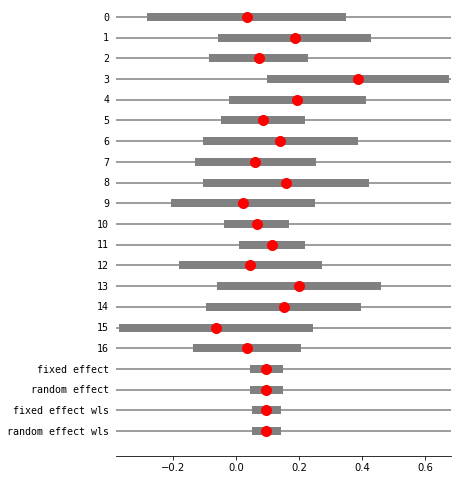

In [200]:
res5 = combine_effects(
    eff3, var_eff3, method_re="iterated", use_t=False
)  # , row_names=rownames)

res5_df = res5.summary_frame()

print("method RE:", res5.method_re)
print(res5.summary_frame())

fig = res5.plot_forest()
fig.set_figheight(8)

### Example of the reboxetine study

The analysis takes the data from the [article from Eyding et al. (2010)](https://www.bmj.com/content/341/bmj.c4737) discussed in page 455-456 and from which the forest plot in Figure 43.1 was derived.

method RE: chi2
RE variance tau2: 0.05605589416643271
                        eff    sd_eff    ci_low    ci_upp  w_fe  w_re
fixed effect       0.154119  0.089729 -0.021746  0.329984   1.0   NaN
random effect      0.160783  0.129872 -0.093762  0.415328   NaN   1.0
fixed effect wls   0.154119  0.125602 -0.092057  0.400295   1.0   NaN
random effect wls  0.160783  0.136132 -0.106032  0.427598   NaN   1.0


Text(0.5, 0, 'Odds ratio (95% CI)')

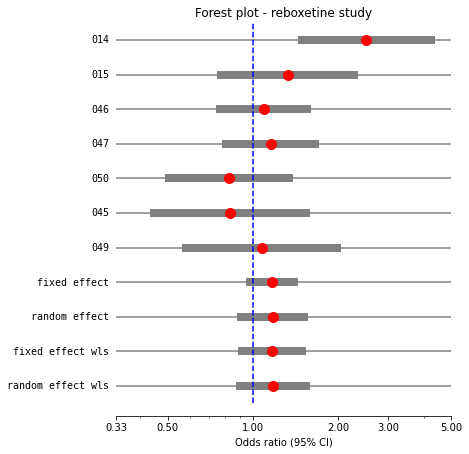

In [233]:
data_eyding = [
    ["014",  60, 126,  34, 128],
    ["015",  47, 110,  40, 111],
    ["046", 132, 252, 124, 247],
    ["047", 109, 238, 101, 239],
    ["050",  48, 144,  54, 143],
    ["045",  30,  88,  33,  86],
    ["049",  29, 106,  27, 104],
]
colnames_eyding = ["study", "count_t", "nobs_t", "count_c", "nobs_c"]
df_eyding = pd.DataFrame(data_eyding, columns=colnames_eyding).set_index('study')
# sample 1 is treatment and sample 2 is control

dta_eyding = df_eyding.values.T

eff_eyding, var_eff_eyding = effectsize_2proportions(*dta_eyding, statistic="or")
# log-odds-ratio and log-risk-ratio can be transformed back to or and rr using the exp function

res_eyding = combine_effects(
    eff_eyding, var_eff_eyding, method_re="chi2", use_t=False, row_names=df_eyding.index,
)

print("method RE:", res_eyding.method_re)
print("RE variance tau2:", res_eyding.tau2)
print(res_eyding.summary_frame().iloc[-4:])

fig = res_eyding.plot_forest(
    use_exp=True, # to show OR instead of logOR
)
fig.set_figheight(7)
plt.axvline(x=1, ls='--', color='blue')

plt.xscale('log')

ax = plt.gca()

# By default, a logarithmic scale uses a LogFormatter
from matplotlib.ticker import ScalarFormatter

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([.33, .5, 1, 2, 3, 5])

ax.set_title('Forest plot - reboxetine study')
ax.set_xlabel('Odds ratio (95% CI)')

In [202]:
# Total effect
stats.fisher_exact([[413, 1058], [455, 1064]])

(0.9128399011196743, 0.2595352712298463)

In [203]:
res_eyding.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 11.756574010710532
pvalue = 0.0676249431325276
df = 6
distr = 'chi2'
tuple = (11.756574010710532, 0.0676249431325276)

In [204]:
# Total heterogeneity in %
round(100 * res_eyding.i2, 1)

49.0

In [205]:
# with with odds ratio instead of log odds ratio
res_eyding_subframe = res_eyding.summary_frame().loc[
    :'random effect',
    ['eff', 'sd_eff', 'ci_low', 'ci_upp']
]
round(res_eyding_subframe.apply(np.exp), 2)

,eff,sd_eff,ci_low,ci_upp
014,2.51,1.31,1.49,4.25
015,1.32,1.32,0.77,2.27
046,1.09,1.20,0.77,1.55
047,1.15,1.20,0.80,1.66
050,0.82,1.28,0.51,1.34
045,0.83,1.37,0.45,1.54
049,1.07,1.37,0.58,1.98
fixed effect,1.17,1.09,0.98,1.39
random effect,1.17,1.14,0.91,1.51


In [206]:
# Odds ratio
np.exp(res_eyding.eff)

array([2.51336898, 1.32420635, 1.09112903, 1.1545015 , 0.82407407,
       0.830721  , 1.07407407])

In [207]:
# 95% CI of the odds ratio
np.exp(res_eyding.conf_int_samples())

array([[1.48615459, 0.7707871 , 0.76800148, 0.80402743, 0.50784043,
        0.447326  , 0.58244518],
       [4.25058316, 2.2749764 , 1.55020869, 1.65774656, 1.3372273 ,
        1.5427169 , 1.98067586]])

In [208]:
# Weights for fixed effect situation
1/var_eff_eyding

array([13.9143513 , 13.11748621, 31.1490689 , 29.34821992, 16.39224046,
       10.0254981 , 10.25706022])

In [209]:
res_eyding.weights_fe

array([13.9143513 , 13.11748621, 31.1490689 , 29.34821992, 16.39224046,
       10.0254981 , 10.25706022])

In [210]:
# Relative weights for random effect situation
res_eyding.weights_re / sum(res_eyding.weights_re)

array([0.13185003, 0.12749867, 0.19132125, 0.18713961, 0.14408635,
       0.10825823, 0.10984586])

In [211]:
res_eyding.weights_rel_re

array([0.13185003, 0.12749867, 0.19132125, 0.18713961, 0.14408635,
       0.10825823, 0.10984586])

### Step-by-step

Similarly to the previous example with the Woolf method, we can calculate the different parameters using $ \log\mathrm(OR) = \log(p_1) - \log(1 - p_1) - \log(p_2) + \log(1 - p_2) $ and $ \log(\operatorname{SE})= \sqrt{1/a + 1/b + 1/c + 1/d} $, with $ p_1 = a/n_1 $  and $ p_2 = c/n_2 $, and $ n_1 = a + b $ the total number of exposed to treatment (disease + no disease), and $ n_2 = c + d $ the total numner of not exposed to treatment.

In [212]:
# for example for stydy #014
data014 = data_eyding[0][1:]
print(data014)

[60, 126, 34, 128]


In [213]:
res_eyding.summary_frame().iloc[0]

eff       0.921624
sd_eff    0.268083
ci_low    0.396192
ci_upp    1.447056
w_fe      0.112028
w_re      0.131850
Name: 014, dtype: float64

In [214]:
a, n1, c, n2 = data014
b, d = n1 - a, n2 - c
p1, p2 = a/n1, c/n2

log_or_014 = np.log(p1) - np.log(1-p1) - np.log(p2) + np.log(1-p2)
log_se_014 = np.sqrt(1/a + 1/b + 1/c + 1/d)

conf=0.95
z = stats.norm.ppf((1 + conf) /2) # same as stats.norm.isf((1 - conf) /2)

print(f"Log(OR) for study `014` = {log_or_014:.5f} with log(SE) = {log_se_014:.5f}")
print(f"Its 95% CI extends from {log_or_014 - z*log_se_014:.4f} to {log_or_014 + z*log_se_014:.4f}")

print(f"OR for study `014` = {np.exp(log_or_014):.2f} with SE = {np.exp(log_se_014):.2f}")
print(f"Its 95% CI extends from {np.exp(log_or_014 - z*log_se_014):.2f} to {np.exp(log_or_014 + z*log_se_014):.2f}")

Log(OR) for study `014` = 0.92162 with log(SE) = 0.26808
Its 95% CI extends from 0.3962 to 1.4471
OR for study `014` = 2.51 with SE = 1.31
Its 95% CI extends from 1.49 to 4.25


We can compute Cochran's $Q$ with $ Q = \sum w_i(E_i-E)^2 $ where $ E = \frac{\sum w_iE_i}{\sum w_i} $, as discussed earlier.

Also remember that $ I^2 = 100\%  \frac{Q - \mathrm{Df}}{Q} $.

In [215]:
df_eyding = len(eff_eyding) - 1

Q_eyding = sum(res_eyding.weights_fe * (res_eyding.effect - res_eyding.mean_effect_fe)**2)
I_eyding = (Q_eyding - df_eyding)/Q_eyding
pvalue_homogen_eyding = 1 - stats.chi2.cdf(x = Q_eyding, df=df_eyding)

print(f"Cochrane Q = {Q_eyding:.3f} and I² = {100*I_eyding:.1f}%, with P value for homogeneity = \
{pvalue_homogen_eyding:.3f}")

Cochrane Q = 11.757 and I² = 49.0%, with P value for homogeneity = 0.068


For the weight, in _fixed effect_ situation, $ \mathrm{weight_{fe}} = \frac{1}{\operatorname{Var}} $ (see above). For the _random effect_ situation we needs to compute a $\tau^2$ value that will serve as a correction.

For the calculation of $\tau^2$ using the $\chi^2$ (also nammed DerSimonian and Laird) method, we need $ q = \sum{w_iE_i^2} - \frac{(\sum{w_iE_i})^2}{\sum{w_i}} $ and another constant  $ c = \frac{\sum{w_i} - \sum{w_i^2}}{\sum{w_i}} $.

Thus, $ \tau^2 = \frac{q - \mathrm{Df}}{c} $.

Finally, the weights for the _random effect_ are obtained with $ \mathrm{weight_{re}} = \frac{1}{\operatorname{Var} + \tau^2} $

In [216]:
weights_eyding = 1/var_eff_eyding # weights fixed effect

q_eyding = (weights_eyding * eff_eyding**2).sum() - ((weights_eyding * eff_eyding).sum())**2 / weights_eyding.sum()
c_eyding = weights_eyding.sum() - (weights_eyding**2).sum() / weights_eyding.sum()
tau_eyding = (q_eyding - df_eyding)/c_eyding
weights_eyding_re = 1/(var_eff_eyding + tau_eyding) # weights random effect

print(f"tau2 = {tau_eyding:.3f}")
print("relative weights for random effect:", weights_eyding_re/weights_eyding_re.sum())

tau2 = 0.056
relative weights for random effect: [0.13185003 0.12749867 0.19132125 0.18713961 0.14408635 0.10825823
 0.10984586]


In [217]:
# of note q is same as Cochrane's Q
q_eyding

11.756574010710532

In [218]:
E_eyding_re = eff_eyding * weights_eyding_re
E_bar_eyding_re = sum(E_eyding_re) / sum(weights_eyding_re)
var_bar_eyding_re = 1 / sum(weights_eyding_re)
SE_bar_eyding_re= var_bar_eyding_re**.5
t_crit_eyding = stats.norm().ppf((1+.95)/2) # we didn't use t-distribution with combine_effect()

# Z_eyding_re = E_bar_eyding_re/SE_bar_eyding_re
# pvalue_eyding_re = 2 * (1 - stats.t.cdf(x = abs(Z_eyding_re), df=df_eyding))

print(f"Combined effect size = {E_bar_eyding_re:.5f} with SE = {SE_bar_eyding_re:.5f} and the 95% CI ranging from {E_bar_eyding_re - t_crit_eyding*SE_bar_eyding_re:.4f} to {E_bar_eyding_re + t_crit_eyding*SE_bar_eyding_re:.4f}")
print(f"The 95% CI of the total OR of {np.exp(E_bar_eyding_re):.2f} extends from {np.exp(E_bar_eyding_re - t_crit_eyding*SE_bar_eyding_re):.2f} to {np.exp(E_bar_eyding_re + t_crit_eyding*SE_bar_eyding_re):.2f}")
# print(f"Z statistic = {Z_eyding_re:.2f} with an associated P value = {pvalue_eyding_re:.5f}")

Combined effect size = 0.16078 with SE = 0.12987 and the 95% CI ranging from -0.0938 to 0.4153
The 95% CI of the total OR of 1.17 extends from 0.91 to 1.51


### Meta-analysis using flexible random-effects distribution models

In meta-analysis in medical studies, random-effects models have been the primary statistical tools for quantitative evaluation of treatment effects that account for betweenstudies heterogeneity. Conventionally, the _normal distribution_ assumption has been adopted in most systematic reviews due to its computational and conceptual simplicity. However, the shape of the random-effects distribution reflects how the treatment effects parameters (e.g., mean difference, log relative risk) are distributed in the target population, and are directly associated with the fundamental heterogeneity of treatment effects. If the normal distribution assumption diverges drastically from the true heterogeneous structure, the overall results of the meta-analyses may be misleading.

[New methods](https://arxiv.org/ftp/arxiv/papers/2003/2003.04598.pdf) propose the random-effects meta-analysis with flexible distribution models that can flexibly express skewness, kurtosis, and tailweight: (1) skew normal distribution, (2) skew t-distribution, (3) asymmetric Subbotin distribution, (4) Jones-Faddy distribution, and (5) sinh-arcsinh distribution.

The overall conclusions and interpretations of meta-analyses can be dramatically altered if the normal distribution assumption is not suitable.

### Mantel-Hanszel odds-ratio using contingency tables

the meta-analysis functions currently do not include the Mantel-Hanszel method. However, the fixed effects results can be computed directly using StratifiedTable as illustrated later. Here we use the `catheter` dataset from the R package `R meta`, with `n.trt` and `n.ctrl` the number of subjects , and `col.trt` and `col.ctrl` the number of events in the _treatment_ and _control_ groups respectively.

In [219]:
catheter = pd.read_csv("https://raw.githubusercontent.com/sbwiecko/intro_statistique_R/master/data/catheter.csv", index_col=0)

catheter.head()

,Name,n.trt,n.ctrl,col.trt,col.ctrl,inf.trt,inf.ctrl
1,Ciresi,124,127,15.0,21.0,13.0,14.0
2,George,44,35,10.0,25.0,1.0,3.0
3,Hannan,68,60,22.0,22.0,5.0,7.0
4,Heard,151,157,60.0,82.0,5.0,6.0
5,vanHeerden,28,26,4.0,10.0,NaN,NaN


In [220]:
df_catheter = catheter[["Name", "col.trt", "n.trt",  "col.ctrl", "n.ctrl"]].set_index("Name")
df_catheter = df_catheter.iloc[[12,5,4,2,11,3,10,0,7,9,1]]
df_catheter

,col.trt,n.trt,col.ctrl,n.ctrl
Name,,,,
Tennenberg,8.0,137,32.0,145
Maki,28.0,208,47.0,195
vanHeerden,4.0,28,10.0,26
Hannan,22.0,68,22.0,60
Bach(b),2.0,116,16.0,117
Heard,60.0,151,82.0,157
Collins,2.0,98,25.0,139
Ciresi,15.0,124,21.0,127
Ramsay,45.0,199,63.0,189


                    eff  sd_eff  ci_low  ci_upp  w_fe  w_re
Tennenberg         0.22    1.52    0.10    0.49  1.07  1.10
Maki               0.49    1.30    0.29    0.82  1.17  1.12
vanHeerden         0.27    1.96    0.07    1.00  1.02  1.06
Hannan             0.83    1.45    0.40    1.72  1.08  1.10
Bach(b)            0.11    2.14    0.02    0.49  1.02  1.05
Heard              0.60    1.26    0.38    0.95  1.23  1.13
Collins            0.09    2.11    0.02    0.41  1.02  1.05
Ciresi             0.69    1.44    0.34    1.42  1.09  1.11
Ramsay             0.58    1.26    0.37    0.92  1.24  1.13
Trazzera           0.47    1.43    0.23    0.94  1.09  1.11
George             0.12    1.68    0.04    0.33  1.04  1.08
fixed effect       0.47    1.11    0.38    0.58  2.72   NaN
random effect      0.38    1.25    0.25    0.58   NaN  2.72
fixed effect wls   0.47    1.18    0.34    0.65  2.72   NaN
random effect wls  0.38    1.25    0.25    0.58   NaN  2.72


Text(0.5, 1.0, 'Forest plot - Catheter dataset')

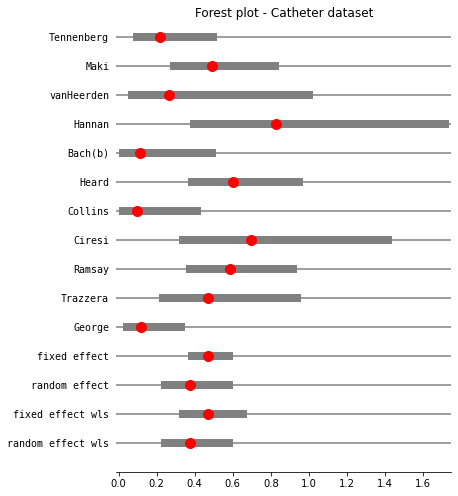

In [221]:
res_catheter = combine_effects(
     *effectsize_2proportions(*df_catheter.values.T, statistic="or"),
     use_t=False,
     row_names=df_catheter.index,
)

print(round(res_catheter.summary_frame().apply(np.exp), 2))

fig = res_catheter.plot_forest(use_exp=True)
fig.set_figheight(8)
plt.gca().set_title('Forest plot - Catheter dataset')

In [222]:
res_catheter.test_homogeneity()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 24.90220481352818
pvalue = 0.005533987983273774
df = 10
distr = 'chi2'
tuple = (24.90220481352818, 0.005533987983273774)

In [223]:
# we need to create a 2 x 2 x k contingency table to be used with StratifiedTable.
t, nt, c, nc = df_catheter.values.T
counts = np.column_stack([t, nt - t, c, nc - c])
ctables = counts.T.reshape(2, 2, -1)
ctables[:, :, 0]

array([[  8., 129.],
       [ 32., 113.]])

In [224]:
counts[0]

array([  8., 129.,  32., 113.])

In [225]:
df_catheter.values.T.T[0]

array([  8., 137.,  32., 145.])

In [226]:
import statsmodels.stats.api as smstats

st = smstats.StratifiedTable(ctables.astype(np.float64))

st.logodds_pooled_confint()

(-1.0102672315383547, -0.6084890097914877)

In [227]:
print(st.test_equal_odds())

pvalue      0.00266808399022056
statistic   26.93358948598208


In [228]:
# MHtest
print(st.test_null_odds())

pvalue      1.2212453270876722e-15
statistic   64.11077206665642


In [229]:
print(st.summary())

                   Estimate   LCB    UCB  
------------------------------------------
Pooled odds           0.445   0.364  0.544
Pooled log odds      -0.809  -1.010 -0.608
Pooled risk ratio     0.560               
                                          
                 Statistic P-value 
-----------------------------------
Test of OR=1        64.111   0.000 
Test constant OR    26.934   0.003 
                       
-----------------------
Number of tables   11  
Min n              54  
Max n             403  
Avg n             235  
Total n          2585  
-----------------------


In [230]:
print(round(res_catheter.summary_frame().apply(np.exp).iloc[-4:-3][['eff', 'ci_low', 'ci_upp']], 2))

               eff  ci_low  ci_upp
fixed effect  0.47    0.38    0.58


The results are not totally identical between the _Woolf and inverse variance_ (previous section), that can be used to estimate the pooled odds ratio with fixed effects, and the _Mantel-Haenszel_ method, which is generally the _most robust_ (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5287121/).

A confidence interval for the Mantel-Haenszel odds ratio in StatsDirect is calculated using the Robins, Breslow and Greenland variance formula (Robins et al., 1986) or by the method of Sato (1990) if the estimate of the odds ratio can not be determined. A chi-square test statistic is given with its associated probability that the pooled odds ratio is equal to one.

There are at least two other ways to do a fixed effects meta-analysis of binary data. _Peto's method_ is a computationally simpler approximation to the Mantel-Haenszel approach. It is also possible to weight the individual odds ratios according to their estimated variances. The Mantel-Haenszel method is superior if there are trials with small numbers of events (less than 5 or so in either group).

## Funnel plots

A [funnel plot](https://psmu.improvement.nhs.uk/psc-shared-library/measurement-evidence-base/16-funnel-plots-for-comparing-institutional-performance/file) is a scatterplot of treatment effect against a measure of study precision. It is used primarily as a visual aid for detecting bias or systematic heterogeneity. A symmetric inverted funnel shape arises from a 'well-behaved' data set, in which publication bias is unlikely. An asymmetric funnel indicates a relationship between treatment effect estimate and study precision. This suggests the possibility of either publication bias or a systematic difference between studies of higher and lower precision (typically 'small study effects'). Asymmetry can also arise from use of an inappropriate effect measure. Whatever the cause, an asymmetric funnel plot leads to doubts over the appropriateness of a simple meta-analysis and suggests that there needs to be investigation of possible causes.

In [231]:
from funnelplot.core import funnel
from pydataset import data

dataset=data('Caschool')
dataset.head()


,distcod,county,district,grspan,enrltot,teachers,calwpct,mealpct,computer,testscr,compstu,expnstu,str,avginc,elpct,readscr,mathscr
1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000
2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024
3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024
4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000
5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024


C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\funnelplot\core.py:14: RuntimeWarning: invalid value encountered in true_divide
  return band / np.sqrt(group_size)
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\funnelplot\core.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return band / np.sqrt(group_size)
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\funnelplot\core.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return band / np.sqrt(group_size)
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\funnelplot\core.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return band / np.sqrt(group_size)
C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\funnelplot\core.py:14: RuntimeWarning: divide by zero encountered in true_divide
  return band / np.sqrt(group_size)
C:\Users\Sébastien\AppData\Local\Pro

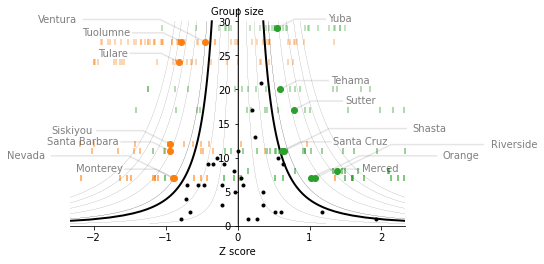

In [232]:
funnel(df=data("Caschool"), x="testscr", group="county", error_mode="data");

However options are missing in Python to plot comprehensive visualizations of forest plots, subgroups and funnel plots, compared to R.

## Implementation in R using rmeta

```r
library('rmeta')
data(catheter)

a <- meta.MH( # Fixed effects (Mantel-Haenszel) meta-analysis
    n.trt,
    n.ctrl,
    col.trt,
    col.ctrl,
    data=catheter,
    names=Name,
    subset=c(13,6,5,3,7,12,4,11,1,8,10,2))

summary(a)

# also possible
metabin(
    col.trt, # Number of events in experimental group
    n.trt,   # Number of observations in experimental group
    col.ctrl,# Number of events in control group
    n.ctrl,  # Number of observations in control group
    data=catheter,
    sm="OR", # summary measure
    Q.Cochrane=FALSE,
    method="MH",
    method.tau="DL",
    hakn=FALSE,
    backtransf=FALSE)

plot(a, summlabel='Total')
funnelplot(a)

metaplot(
    a$logOR,
    a$selogOR,
    nn=a$selogOR^-2,
    a$names, # equiv 1/a$selogOR^2
    summn=a$logMH,
    sumse=a$selogMH,
    sumnn=a$selogMH^-2,
    logeffect=TRUE,
    colors=meta.colors(
        box="magenta",
        lines="blue",
        zero="red",
        summary="orange",
        text="forestgreen"))
```